This notebook goes over all of the major components of this project:
1. Simulation: Can be thought of as a black box that takes in a solution and outputs demand coverage. Used to evaluate solutions and generate a dataset.
2. Machine learning: A multilayer perceptron (MLP) is trained to predict coverage given a solution.
3. Optimization: The MLP is embedded within a MIP which attempts to find the solution that the MLP predicts will have the highest coverage.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import power_transform
import matplotlib.pyplot as plt
from IPython.display import display
from ems_data import EMSData, TORONTO_AVG_CALLS_PER_DAY, TORONTO_N_AMBULANCES
from simulation import Simulation
from neural_network import MLP
from mip_models import *

Before doing anything, we need to load the data. The EMSData class reads and preprocesses the data for usage in simulation and MIP models.

In [2]:
# Skip this cell if you already have ems_data.pkl and don't need to regenerate with different parameters
ems_data = EMSData(region_id=1, x_intervals=10, y_intervals=10, verbose=True)
ems_data.save_instance('ems_data.pkl')

Computing (median) travel times: 100%|██████████| 13997282/13997282 [01:06<00:00, 209587.32it/s]


In [2]:
ems_data = EMSData.load_instance('ems_data.pkl')

n_stations = len(ems_data.stations)
n_demand_nodes = len(ems_data.demand_nodes)
demand = ems_data.demand_nodes.demand
print(f"# stations: {n_stations}")
print(f"# demand nodes: {n_demand_nodes}")

# stations: 46
# demand nodes: 67


In [3]:
# Instance parameters
N_AMBULANCES = 50
FACILITY_CAPACITY = 5
ARRIVAL_RATE = TORONTO_AVG_CALLS_PER_DAY
# Parameter for MEXCLP
BUSY_FRACTION = 0.75
# Parameters for p-median with queuing model
SERVICE_RATE = 32
SUCCESS_PROB = 0.9

# Simulation
The Simulation class pulls relevant data from an EMSData instance and runs the simulation. Simulations are used to evaluate a solution (i.e., the number of ambulances at each station) as well as generate a dataset for the MLP.

In [4]:
# Pickled Simulation instance is used by HTCondor jobs
# Currently increasing arrival rate beyond TORONTO_AVG_CALLS_PER_DAY to make the problem interesting
# For running in this notebook and curating the dataset, use just 1 replication; should use 5 replications for final experiments
sim = Simulation(data=ems_data, avg_calls_per_day=ARRIVAL_RATE, n_days=100, n_replications=1)
sim.save_instance('simulation.pkl')

def evaluate_solution(solution):
    """Run multiple replications and evaluate demand-weighted coverage and average response time."""
    result = sim.run(solution)
    result = result.sum()  # Sum over replications

    total_covered = sum(result[f'n_covered_{i}'] for i in range(n_demand_nodes))
    total_response_time = sum(result[f'response_time_{i}'] for i in range(n_demand_nodes))
    total_calls_from_demand_nodes = sum(result[f'n_calls_from_{i}'] for i in range(n_demand_nodes))
    
    coverage = total_covered / total_calls_from_demand_nodes
    avg_response_time = total_response_time / total_calls_from_demand_nodes

    return coverage, avg_response_time

In [5]:
# Evaluate solution that places 1 ambulance at each station
solution = [1]*n_stations
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Demand-weighted coverage: 0.8217168011738811
Demand-weighted average response time: 6.982216847622462


In [6]:
# Evaluate solution that places 1000 ambulances at each station
solution = [1000]*n_stations
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Demand-weighted coverage: 0.9578561269556104
Demand-weighted average response time: 5.473425828395666


The dataset was generated using HTCondor and is stored in `dataset.csv`. `n_jobs = 200` jobs are run, each job performs the simulation for `solutions_per_job = 500` solutions, and `n_replications = 1` replication(s) are ran per solution. The resulting dataset has `n_jobs * solutions_per_job` samples, one per solution (the `n_replications` replication(s) for a solution are aggregated into a single sample).

To generate `dataset.csv`:
1. Run `htcondor_setup.py` to generate `settings<Process>.csv` files. These files contain the solutions to be simulated on each HTCondor job. For the latest dataset, I ran this:

`python htcondor_setup.py --region_id 1 --ambulances 25 100 --zeros 0 20 --n_consecutive 5`

2. Move the following files to the HTCondor submit server:
    - `simulation.sub`
    - `run_job.sh`
    - `run_job.py`
    - `simulation.py`
    - `settings$(Process).csv` for each `Process`
    - `simulation.pkl`
    - `sim-env.tar.gz` (see https://chtc.cs.wisc.edu/uw-research-computing/conda-installation, Option 1; the environment must have numpy and pandas)

    The last two files go to your Squid directory (see https://chtc.cs.wisc.edu/uw-research-computing/file-avail-squid).
    
3. Run `condor_submit simulation.sub`. Once the jobs are done, move the `results<Process>.csv` files to a new folder named `sim_results`. Then run `create_dataset.py` to create the dataset from the `results<Process>.csv` files. For each solution, the script sums the `n_covered_<i>`, `response_time_<i>`, `n_calls_from_<i>`, `n_blocked_<j>`, and `n_calls_to_<j>`, columns over the replications, and defines `p_covered_<i> = n_covered_<i>/n_calls_from_<i>`, `avg_response_time_<i> = response_time_<i>/n_calls_from_<i>`, and `p_blocked_<j> = n_blocked_<j>/n_calls_to_<j>`. The resulting dataset has columns `solution_<j>` for `j` in `range(n_stations)`, `p_covered_<i>` for `i` in `range(n_demand_nodes)`, `avg_response_time_<i>` for `i` in `range(n_demand_nodes)`, and `p_blocked_<j>` for `j` in `range(n_stations)`.

In [7]:
# Toronto dataset settings:
# sim = Simulation(data=ems_data, avg_calls_per_day=1000, remove_outliers=True, n_days=100, n_replications=1)
# python htcondor_setup.py --region_id 1 --ambulances 50 100 --zeros 0 20 --n_consecutive 5
dataset = pd.read_csv('dataset_toronto.csv')
with pd.option_context('display.max_columns', None):
    display(dataset)

,solution_0,solution_1,solution_2,solution_3,solution_4,solution_5,solution_6,solution_7,solution_8,solution_9,solution_10,solution_11,solution_12,solution_13,solution_14,solution_15,solution_16,solution_17,solution_18,solution_19,solution_20,solution_21,solution_22,solution_23,solution_24,solution_25,solution_26,solution_27,solution_28,solution_29,solution_30,solution_31,solution_32,solution_33,solution_34,solution_35,solution_36,solution_37,solution_38,solution_39,solution_40,solution_41,solution_42,solution_43,solution_44,solution_45,coverage_0,coverage_1,coverage_2,coverage_3,coverage_4,coverage_5,coverage_6,coverage_7,coverage_8,coverage_9,coverage_10,coverage_11,coverage_12,coverage_13,coverage_14,coverage_15,coverage_16,coverage_17,coverage_18,coverage_19,coverage_20,coverage_21,coverage_22,coverage_23,coverage_24,coverage_25,coverage_26,coverage_27,coverage_28,coverage_29,coverage_30,coverage_31,coverage_32,coverage_33,coverage_34,coverage_35,coverage_36,coverage_37,coverage_38,coverage_39,coverage_40,coverage_41,coverage_42,coverage_43,coverage_44,coverage_45,coverage_46,coverage_47,coverage_48,coverage_49,coverage_50,coverage_51,coverage_52,coverage_53,coverage_54,coverage_55,coverage_56,coverage_57,coverage_58,coverage_59,coverage_60,coverage_61,coverage_62,coverage_63,coverage_64,coverage_65,coverage_66,avg_response_time_0,avg_response_time_1,avg_response_time_2,avg_response_time_3,avg_response_time_4,avg_response_time_5,avg_response_time_6,avg_response_time_7,avg_response_time_8,avg_response_time_9,avg_response_time_10,avg_response_time_11,avg_response_time_12,avg_response_time_13,avg_response_time_14,avg_response_time_15,avg_response_time_16,avg_response_time_17,avg_response_time_18,avg_response_time_19,avg_response_time_20,avg_response_time_21,avg_response_time_22,avg_response_time_23,avg_response_time_24,avg_response_time_25,avg_response_time_26,avg_response_time_27,avg_response_time_28,avg_response_time_29,avg_response_time_30,avg_response_time_31,avg_response_time_32,avg_response_time_33,avg_response_time_34,avg_response_time_35,avg_response_time_36,avg_response_time_37,avg_response_time_38,avg_response_time_39,avg_response_time_40,avg_response_time_41,avg_response_time_42,avg_response_time_43,avg_response_time_44,avg_response_time_45,avg_response_time_46,avg_response_time_47,avg_response_time_48,avg_response_time_49,avg_response_time_50,avg_response_time_51,avg_response_time_52,avg_response_time_53,avg_response_time_54,avg_response_time_55,avg_response_time_56,avg_response_time_57,avg_response_time_58,avg_response_time_59,avg_response_time_60,avg_response_time_61,avg_response_time_62,avg_response_time_63,avg_response_time_64,avg_response_time_65,avg_response_time_66,blocking_prob_0,blocking_prob_1,blocking_prob_2,blocking_prob_3,blocking_prob_4,blocking_prob_5,blocking_prob_6,blocking_prob_7,blocking_prob_8,blocking_prob_9,blocking_prob_10,blocking_prob_11,blocking_prob_12,blocking_prob_13,blocking_prob_14,blocking_prob_15,blocking_prob_16,blocking_prob_17,blocking_prob_18,blocking_prob_19,blocking_prob_20,blocking_prob_21,blocking_prob_22,blocking_prob_23,blocking_prob_24,blocking_prob_25,blocking_prob_26,blocking_prob_27,blocking_prob_28,blocking_prob_29,blocking_prob_30,blocking_prob_31,blocking_prob_32,blocking_prob_33,blocking_prob_34,blocking_prob_35,blocking_prob_36,blocking_prob_37,blocking_prob_38,blocking_prob_39,blocking_prob_40,blocking_prob_41,blocking_prob_42,blocking_prob_43,blocking_prob_44,blocking_prob_45
0,0,0,3,0,2,0,0,4,10,1,0,0,5,0,0,2,1,0,0,3,1,0,4,1,0,3,3,1,2,1,0,2,2,0,2,1,3,4,1,1,3,2,0,6,8,0,0.666667,0.300000,0.652174,0.664062,0.750000,1.000000,0.407643,0.562069,0.579450,0.629333,0.743034,0.898305,0.922261,0.500000,0.504573,0.753680,0.884268,0.898004,0.908629,0.905812,0.915449,1.000000,0.943396,0.974734,0.965167,0.934954,0.964894,0.962656,0.850360,1.000000,0.976744,0.961376,0.969170,0.958443,0.931929,0.916519,0.787517,0.666667,0.000000,0.909091,0.960707,0.969225,0.918900,0.749554,0.8

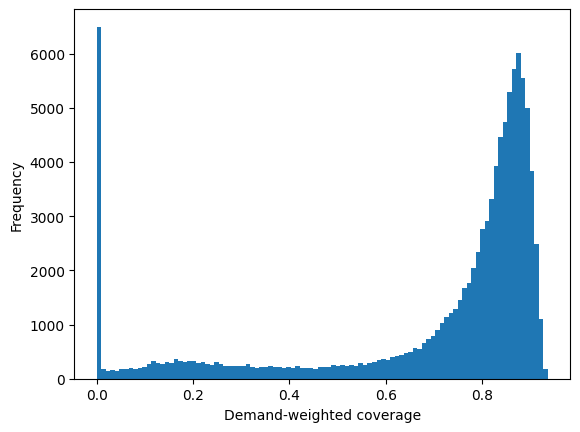

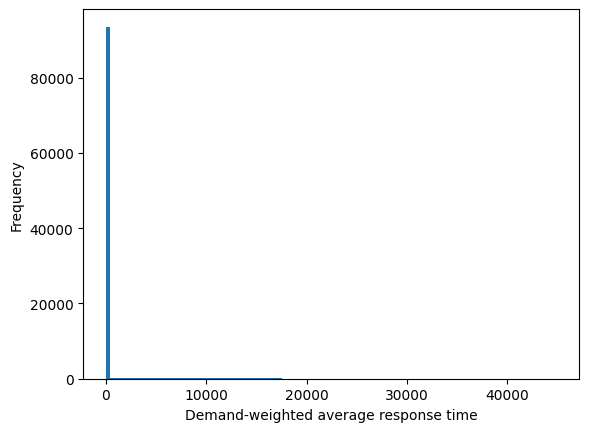

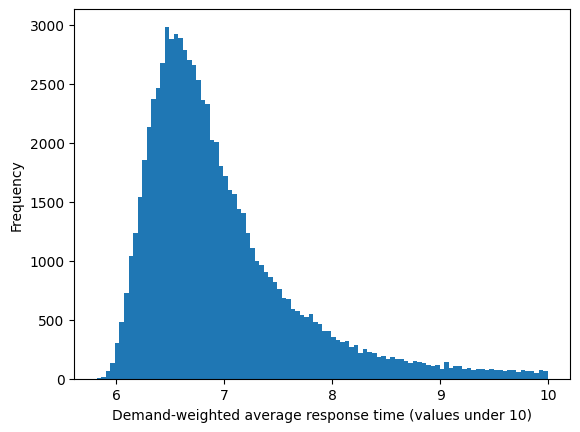

In [8]:
# Read dataset into arrays
X = dataset[[f'solution_{i}' for i in range(n_stations)]].to_numpy()
y_cov = dataset[[f'coverage_{i}' for i in range(n_demand_nodes)]].to_numpy()
y_med = dataset[[f'avg_response_time_{i}' for i in range(n_demand_nodes)]].to_numpy()

# Plot histograms for demand-weighted coverage and average response time
d_y_cov = y_cov@demand/demand.sum()
d_y_med = y_med@demand/demand.sum()

plt.hist(d_y_cov, bins=100)
plt.xlabel("Demand-weighted coverage")
plt.ylabel("Frequency")
plt.show()

plt.hist(d_y_med, bins=100)
plt.xlabel("Demand-weighted average response time")
plt.ylabel("Frequency")
plt.show()

plt.hist(d_y_med[d_y_med < 10], bins=100)
plt.xlabel("Demand-weighted average response time (values under 10)")
plt.ylabel("Frequency")
plt.show()

95th percentile of demand-weighted average response time: 3311.958025297524


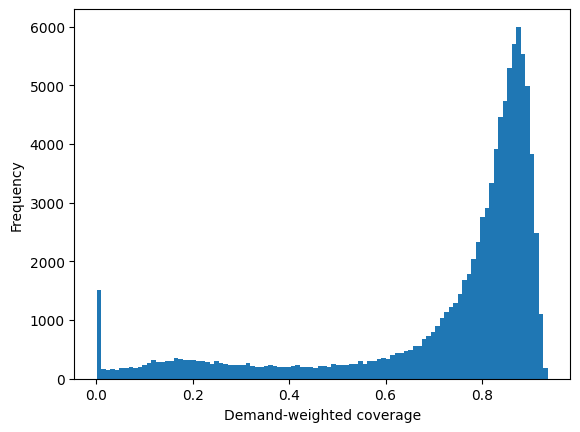

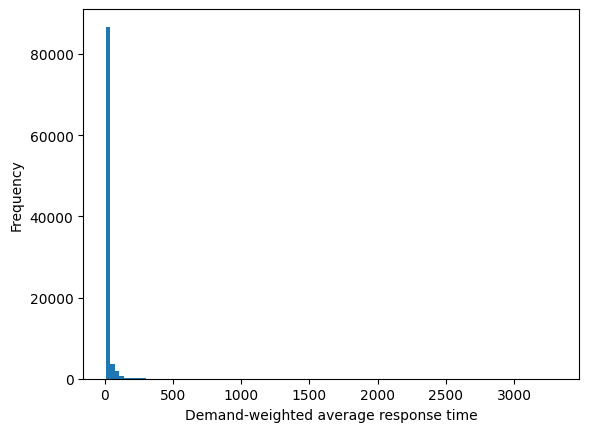

In [9]:
# Eliminate outliers (w.r.t. demand-weighted average response time)
# Although it would be nice to learn from these samples, they skew the target way too much even after Box-Cox transformation
# TODO: I think Coverage-MLP does not benefit from removing outliers
percentile = 95
threshold = np.percentile(d_y_med, percentile)
print(f"{percentile}th percentile of demand-weighted average response time: {threshold}")
X = X[d_y_med < threshold]
y_cov = y_cov[d_y_med < threshold]
y_med = y_med[d_y_med < threshold]

# Plot histograms for demand-weighted coverage and average response time
d_y_cov = y_cov@demand/demand.sum()
d_y_med = y_med@demand/demand.sum()

plt.hist(d_y_cov, bins=100)
plt.xlabel("Demand-weighted coverage")
plt.ylabel("Frequency")
plt.show()

plt.hist(d_y_med, bins=100)
plt.xlabel("Demand-weighted average response time")
plt.ylabel("Frequency")
plt.show()

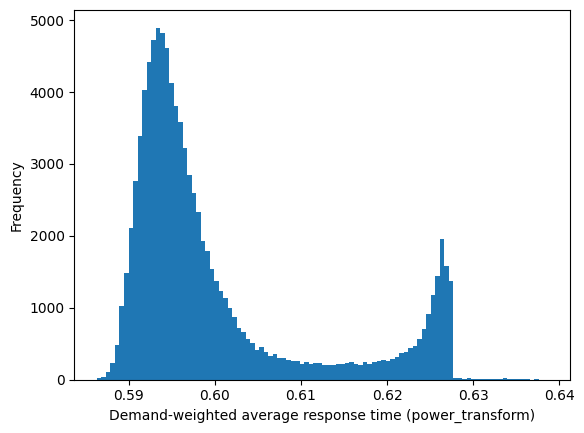

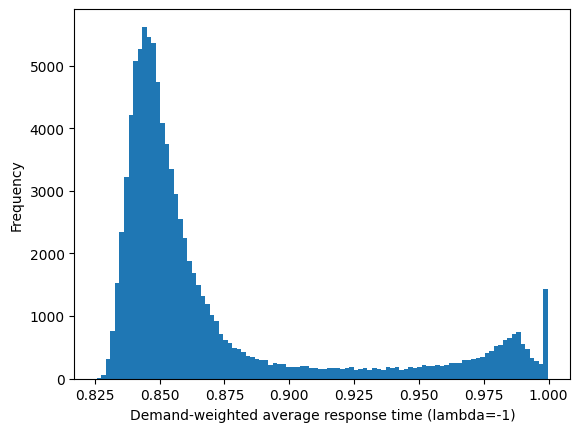

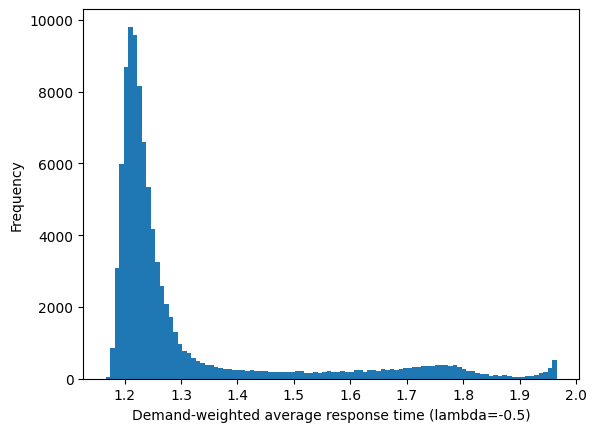

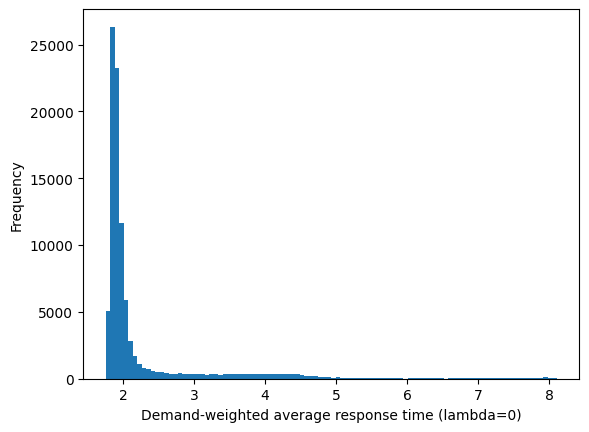

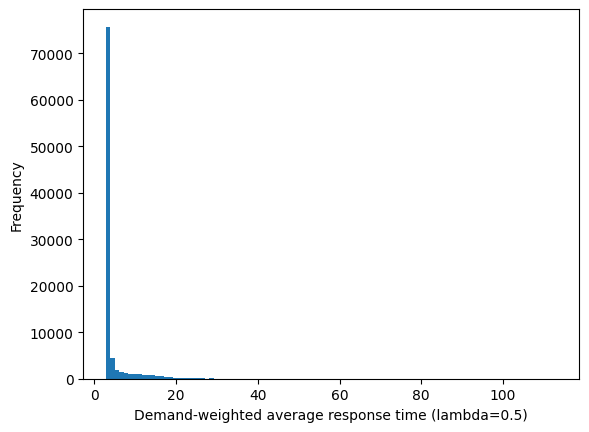

In [10]:
# Apply Box-Cox transformation to y_med to flatten it out a bit and bring the right tail in (too hard to learn otherwise)

# scikit-learn's power_transform which automatically chooses lambda
y_med_bc = power_transform(y_med, method='box-cox', standardize=False)
d_y_med_bc = y_med_bc@demand/demand.sum()
plt.hist(d_y_med_bc, bins=100)
plt.xlabel("Demand-weighted average response time (power_transform)")
plt.ylabel("Frequency")
plt.show()

# My own implementation which lets me choose lambda
def boxcox(x, lmbda):
    """The Box-Cox transformation."""
    return (x**lmbda - 1) / lmbda if lmbda != 0 else np.log(x)

for lmbda in [-1, -0.5, 0, 0.5]:
    y_med_bc = boxcox(y_med, lmbda)
    d_y_med_bc = y_med_bc@demand/demand.sum()
    plt.hist(d_y_med_bc, bins=100)
    plt.xlabel(f"Demand-weighted average response time (lambda={lmbda})")
    plt.ylabel("Frequency")
    plt.show()

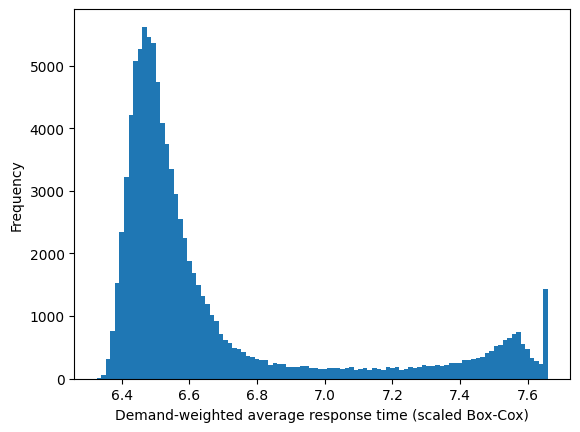

In [11]:
# Pick the best lambda by visual inspection
lmbda = -1
y_med_bc = boxcox(y_med, lmbda)
d_y_med_bc = y_med_bc@demand/demand.sum()

# Scale by constant to get big peak close to original data
def find_modal_bin(data, bins=100, lb=None, ub=None):
    if lb is not None:
        data = data[data >= lb]
    if ub is not None:
        data = data[data <= ub]
    counts, bin_edges = np.histogram(data, bins=bins)
    max_index = np.argmax(counts)
    mode = (bin_edges[max_index] + bin_edges[max_index + 1])/2
    return mode

scale = find_modal_bin(d_y_med, ub=10)/find_modal_bin(d_y_med_bc)
y_med = scale * y_med_bc

d_y_med = y_med@demand/demand.sum()
plt.hist(d_y_med, bins=100)
plt.xlabel("Demand-weighted average response time (scaled Box-Cox)")
plt.ylabel("Frequency")
plt.show()

# Machine Learning
The MLP takes as input the solution and outputs the coverage probabilities for each demand node.

In [12]:
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

In [13]:
# Move dataset into tensors compatible with model and split into train/dev sets (no test set)
X = torch.tensor(X, dtype=torch.float32, device=device)
y_cov = torch.tensor(y_cov, dtype=torch.float32, device=device)
y_med = torch.tensor(y_med, dtype=torch.float32, device=device)
X_train, X_dev, y_cov_train, y_cov_dev, y_med_train, y_med_dev = train_test_split(X, y_cov, y_med, random_state=0, train_size=0.75)
X_train.shape, X_dev.shape

(torch.Size([71250, 46]), torch.Size([23750, 46]))

In [14]:
# First work with coverage models
y_train = y_cov_train
y_dev = y_cov_dev
y_train.shape, y_dev.shape

(torch.Size([71250, 67]), torch.Size([23750, 67]))

In [15]:
# Train MLP for coverage model
demand_weight = torch.tensor(demand/demand.sum(), dtype=torch.float32, device=device)
loss_fn = lambda input, target: MLP.demand_weighted_loss(input, target, demand_weight, MLP.modified_sigmoid)

# mlp = MLP(n_stations, [200], n_demand_nodes, dropout=0.1).to(device)  # Uncomment if you want to start training from scratch
mlp = MLP.load_model('coverage.pt').to(device)  # Uncomment if you want to resume training from a checkpoint
init_train_loss = mlp.evaluate_loss(X_train, y_train, loss_fn)
init_dev_loss = mlp.evaluate_loss(X_dev, y_dev, loss_fn)
print(f"Initial train loss: {init_train_loss}, initial dev loss: {init_dev_loss}")
mlp.fit(X_train, y_train, X_dev, y_dev, loss_fn, patience=20, filepath='coverage.pt', verbose=True)

Evaluating:   0%|          | 0/557 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 186/186 [00:00<00:00, 594.26it/s]


Initial train loss: 3.5947462216350494e-05, initial dev loss: 3.9489006720281105e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 592.36it/s]


Train loss: 4.226793659025836e-05, dev loss: 5.087083463869548e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 577.64it/s]


Train loss: 4.0242146632099e-05, dev loss: 4.299279877787309e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 581.25it/s]


Train loss: 4.2163810834366205e-05, dev loss: 4.454894465866106e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 575.85it/s]


Train loss: 3.949544985437553e-05, dev loss: 4.83125057730113e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 588.61it/s]


Train loss: 4.072632066856482e-05, dev loss: 6.318958406030249e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 586.00it/s]


Train loss: 4.201473943289704e-05, dev loss: 4.4404068087092846e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 592.36it/s]


Train loss: 3.7575630029344835e-05, dev loss: 4.806557203563371e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 555.23it/s]


Train loss: 4.141093767074492e-05, dev loss: 4.363565647876576e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 584.90it/s]


Train loss: 3.910947444444326e-05, dev loss: 5.426928842651633e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 590.48it/s]


Train loss: 4.054943021486938e-05, dev loss: 4.917816928201845e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 605.86it/s]


Train loss: 3.848615139007993e-05, dev loss: 5.02960204226455e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 594.25it/s]


Train loss: 4.069964473938422e-05, dev loss: 4.574070221049049e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 584.91it/s]


Train loss: 4.059797076788208e-05, dev loss: 5.34049057930181e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 565.35it/s]


Train loss: 3.736262818422626e-05, dev loss: 4.2654781290452536e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 581.25it/s]


Train loss: 3.802595765619914e-05, dev loss: 5.018854926180977e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 600.00it/s]


Train loss: 3.838271354927616e-05, dev loss: 4.796532271000998e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 572.31it/s]


Train loss: 3.861193916936029e-05, dev loss: 5.197982101817615e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 608.40it/s]


Train loss: 3.9475601842614676e-05, dev loss: 4.3007764443877696e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 588.61it/s]


Train loss: 3.809223450146403e-05, dev loss: 4.4637033745867056e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 600.00it/s]


Train loss: 4.1456857979861336e-05, dev loss: 5.380347076876971e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 607.17it/s]


Train loss: 3.727095699828249e-05, dev loss: 4.336036674273936e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 600.00it/s]


Train loss: 3.7183066899990335e-05, dev loss: 4.755783460920946e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 599.47it/s]


Train loss: 3.650551032828445e-05, dev loss: 4.684752616893476e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 600.00it/s]


Train loss: 3.859508893403568e-05, dev loss: 4.564278278512096e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 605.86it/s]


Train loss: 3.9375911917120804e-05, dev loss: 5.572376970299765e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 610.48it/s]


Train loss: 3.807182315585873e-05, dev loss: 4.310231400227885e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 613.87it/s]


Train loss: 3.714932312876427e-05, dev loss: 4.610613379076025e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 568.81it/s]


Train loss: 3.910602905124777e-05, dev loss: 4.503725021878429e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 601.86it/s]


Train loss: 3.62516529271951e-05, dev loss: 4.8326522249446594e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 596.16it/s]


Train loss: 3.710377403502271e-05, dev loss: 5.76306710597189e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 596.15it/s]


Train loss: 3.7639815584662485e-05, dev loss: 4.867888925073203e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 605.78it/s]


Train loss: 3.846373919064686e-05, dev loss: 5.1602096441140594e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 596.15it/s]


Train loss: 3.891270395650185e-05, dev loss: 4.7101166802244016e-05


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 607.74it/s]

Train loss: 3.719391082730063e-05, dev loss: 4.667361827266991e-05
Early stopping


In [16]:
# Next work with median models
y_train = y_med_train
y_dev = y_med_dev
y_train.shape, y_dev.shape

(torch.Size([71250, 67]), torch.Size([23750, 67]))

In [17]:
# Train MLP for median model
demand_weight = torch.tensor(demand/demand.sum(), dtype=torch.float32, device=device)
loss_fn = lambda input, target: MLP.demand_weighted_loss(input, target, demand_weight, activation=F.relu)

# mlp = MLP(n_stations, [200], n_demand_nodes, dropout=0.1).to(device)  # Uncomment if you want to start training from scratch
mlp = MLP.load_model('median.pt').to(device)  # Uncomment if you want to resume training from a checkpoint
init_train_loss = mlp.evaluate_loss(X_train, y_train, loss_fn)
init_dev_loss = mlp.evaluate_loss(X_dev, y_dev, loss_fn)
print(f"Initial train loss: {init_train_loss}, initial dev loss: {init_dev_loss}")
mlp.fit(X_train, y_train, X_dev, y_dev, loss_fn, patience=20, filepath='median.pt', verbose=True)

Evaluating: 100%|██████████| 186/186 [00:00<00:00, 643.60it/s]


Initial train loss: 0.00020251114803832024, initial dev loss: 0.00022232989910622372


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 707.23it/s]


Train loss: 0.0003608161708384981, dev loss: 0.00021466243806613706


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 699.24it/s]


Train loss: 0.0002995740950487456, dev loss: 0.00023445889299710917


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 645.58it/s]


Train loss: 0.00034401184485024334, dev loss: 0.0003325616199302634


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 645.84it/s]


Train loss: 0.00031956847185644796, dev loss: 0.00024443659914510425


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 626.15it/s]


Train loss: 0.0003037591415759699, dev loss: 0.00023766364652271334


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 669.07it/s]


Train loss: 0.00031532174889978607, dev loss: 0.00025908561229803843


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 652.63it/s]


Train loss: 0.0003125485764236369, dev loss: 0.0004482696679420769


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 575.78it/s]


Train loss: 0.0003417371065274142, dev loss: 0.00029082538198042465


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 648.09it/s]


Train loss: 0.0003015843104399545, dev loss: 0.00031108911507027716


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 652.63it/s]


Train loss: 0.0002889331530926651, dev loss: 0.00024153040351566711


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 652.63it/s]


Train loss: 0.0003492650870768876, dev loss: 0.0004649664270176895


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 652.64it/s]


Train loss: 0.00028222953300318564, dev loss: 0.00029926653315411197


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 648.08it/s]


Train loss: 0.0002938085103795553, dev loss: 0.00023800837821939862


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 622.07it/s]


Train loss: 0.0002916945377291229, dev loss: 0.00032821943780995516


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 649.33it/s]


Train loss: 0.0003279108234227782, dev loss: 0.000228324887732436


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 661.93it/s]


Train loss: 0.00033838569378529334, dev loss: 0.00025001541824496695


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 601.94it/s]


Train loss: 0.0002838728311259234, dev loss: 0.00020885280312259535


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 639.18it/s]


Train loss: 0.00030272074297005145, dev loss: 0.0002249445233175433


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 659.57it/s]


Train loss: 0.0003046136834891513, dev loss: 0.00021169212902405937


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 671.48it/s]


Train loss: 0.0002962298394152241, dev loss: 0.00021905713683778518


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 652.63it/s]


Train loss: 0.00031421649030556804, dev loss: 0.00026329460224920983


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 654.93it/s]


Train loss: 0.0002882157901248878, dev loss: 0.0006376936107530798


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 671.48it/s]


Train loss: 0.00028930882435095935, dev loss: 0.0002924526552179534


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 675.64it/s]


Train loss: 0.00027881067897961065, dev loss: 0.0003544518893694897


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 650.35it/s]


Train loss: 0.0002958552492263711, dev loss: 0.00022846229000409184


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 654.93it/s]


Train loss: 0.0002997266575408152, dev loss: 0.00031716339492459636


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 666.67it/s]


Train loss: 0.0002952183200920556, dev loss: 0.00042407423887205753


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 645.83it/s]


Train loss: 0.0002724397692829371, dev loss: 0.00029656148741609954


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 671.48it/s]


Train loss: 0.00027905237852399677, dev loss: 0.0002501314355305543


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 664.29it/s]


Train loss: 0.0003133168543897275, dev loss: 0.00023086945771325478


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 663.22it/s]


Train loss: 0.000263049364379166, dev loss: 0.0003392545305609115


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 648.00it/s]


Train loss: 0.00027534852906971715, dev loss: 0.00031986545595634534


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 636.99it/s]


Train loss: 0.00028658914967325693, dev loss: 0.0002651387048027429


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 659.04it/s]


Train loss: 0.0003056940202621678, dev loss: 0.00021058739793339843


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 600.00it/s]


Train loss: 0.0002791663934313284, dev loss: 0.0004183140299675104


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 622.07it/s]


Train loss: 0.0002797821676379004, dev loss: 0.0002218194419003435


Evaluating: 100%|██████████| 186/186 [00:00<00:00, 548.67it/s]

Train loss: 0.00028060837641211324, dev loss: 0.0007051883431935781
Early stopping


# Optimization
The trained MLP is embedded within a MIP which attempts to find the solution that the MLP predicts will have the highest coverage.

In [18]:
# Find the best solutions from the dataset
X = dataset[[f'solution_{i}' for i in range(n_stations)]].to_numpy()
y_cov = dataset[[f'coverage_{i}' for i in range(n_demand_nodes)]].to_numpy()
y_med = dataset[[f'avg_response_time_{i}' for i in range(n_demand_nodes)]].to_numpy()
d_y_cov = y_cov@demand/demand.sum()
d_y_med = y_med@demand/demand.sum()

# Best w.r.t. demand-weighted coverage
best_idx = np.argmax(d_y_cov)
solution = X[best_idx]
print(f"Best w.r.t. coverage: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

# Best w.r.t. demand-weighted average response time
best_idx = np.argmin(d_y_med)
solution = X[best_idx]
print(f"Best w.r.t. average response time: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Best w.r.t. coverage: [0 3 2 3 0 3 2 0 1 5 4 0 1 2 2 3 0 1 3 0 0 1 2 3 1 2 2 3 1 2 1 1 2 3 1 3 5
 5 3 1 5 2 4 2 1 1]
Total ambulances used: 92
Demand-weighted coverage: 0.9356315289648623
Demand-weighted average response time: 5.891428490253099
Best w.r.t. average response time: [2 0 2 1 1 3 1 3 2 1 1 1 2 1 3 3 5 4 3 0 1 1 1 4 6 0 3 1 3 2 1 2 2 2 1 9 0
 1 5 7 2 2 4 2 0 0]
Total ambulances used: 101
Demand-weighted coverage: 0.9350627299311386
Demand-weighted average response time: 5.827907481469546


In [19]:
# Best w.r.t. demand-weighted coverage, at most N_AMBULANCES ambulances
indices = np.where(X.sum(axis=1) <= N_AMBULANCES)[0]
best_idx = indices[np.argmax(d_y_cov[indices])]
solution = X[best_idx]
print(f"Best w.r.t. coverage, at most {N_AMBULANCES} ambulances: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

# Best w.r.t. demand-weighted average response time, at most N_AMBULANCES ambulances
indices = np.where(X.sum(axis=1) <= N_AMBULANCES)[0]
best_idx = indices[np.argmin((d_y_med)[indices])]
solution = X[best_idx]
print(f"Best w.r.t. average response time, at most {N_AMBULANCES} ambulances: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Best w.r.t. coverage, at most 50 ambulances: [3 0 0 3 1 1 3 3 3 1 1 1 1 1 2 2 1 0 0 1 0 1 1 1 1 1 2 1 1 1 1 1 0 1 0 0 3
 2 0 1 0 0 0 1 1 1]
Total ambulances used: 50
Demand-weighted coverage: 0.840907811004111
Demand-weighted average response time: 6.812319191476779
Best w.r.t. average response time, at most 50 ambulances: [1 1 1 1 1 0 0 0 3 0 1 2 1 0 0 1 0 0 1 1 3 1 1 1 1 1 1 4 2 0 1 1 1 3 2 1 2
 0 2 0 1 1 3 2 0 0]
Total ambulances used: 50
Demand-weighted coverage: 0.839687377297459
Demand-weighted average response time: 6.76308558550635


In [20]:
# Daskin's MEXCLP model
solution = mexclp(
    demand=demand,
    distance=ems_data.demand_node_to_station_times,
    threshold=ems_data.response_time_threshold,
    n_ambulances=N_AMBULANCES,
    busy_fraction=BUSY_FRACTION,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=60,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 68 rows, 3396 columns and 4008 nonzeros
Model fingerprint: 0x9954154f
Variable types: 0 continuous, 3396 integer (3350 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-13, 2e-02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 0 rows and 866 columns
Presolve time: 0.01s
Presolved: 68 rows, 2530 columns, 3130 nonzeros
Variable types: 0 continuous, 2530 integer (2480 binary)
Found heuristic solution: objective 0.4980825

Root relaxation: objective 9.752344e-01, 382 iterations, 0.00 seconds (0.00 work units)



In [21]:
# Coverage-MLP
mlp = MLP.load_model('coverage.pt').to(device)
solution = coverage_mlp(
    demand=demand,
    mlp=mlp,
    n_ambulances=N_AMBULANCES,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=60,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1738 rows, 893 columns and 26043 nonzeros
Model fingerprint: 0x07429e95
Variable types: 647 continuous, 246 integer (200 binary)
Coefficient statistics:
  Matrix range     [4e-06, 7e+01]
  Objective range  [3e-06, 7e-02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [7e-02, 7e+01]
Presolve removed 163 rows and 133 columns
Presolve time: 0.06s
Presolved: 1575 rows, 760 columns, 25717 nonzeros
Variable types: 524 continuous, 236 integer (190 binary)

Root relaxation: objective 9.786520e-01, 819 iterations, 0.04 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.97865    

In [22]:
# p-median with queuing
# max_rho = ARRIVAL_RATE/SERVICE_RATE
# rho_values = compute_rho(max_servers=N_AMBULANCES, success_prob=SUCCESS_PROB)
# for i, rho in enumerate(rho_values):
#     if rho > max_rho:
#         facility_capacity = i
#         break
# print(f"facility capacity: {facility_capacity}")
# rho = rho_values[:facility_capacity+1]
rho = compute_rho(max_servers=FACILITY_CAPACITY, success_prob=SUCCESS_PROB)
solution, y = pmedian_with_queuing(
    demand=demand,
    distance=ems_data.demand_node_to_station_times,
    n_ambulances=N_AMBULANCES,
    arrival_rate=ARRIVAL_RATE,
    service_rate=SERVICE_RATE,
    rho=rho,
    time_limit=60,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3380 rows, 3312 columns and 13156 nonzeros
Model fingerprint: 0xe53951ef
Variable types: 3082 continuous, 230 integer (230 binary)
Coefficient statistics:
  Matrix range     [2e-03, 4e+01]
  Objective range  [2e-05, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 12.6544588
Presolve time: 0.01s
Presolved: 3380 rows, 3312 columns, 13156 nonzeros
Variable types: 3082 continuous, 230 integer (230 binary)

Root relaxation: objective 3.241727e+00, 260 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    3.

In [23]:
# Median-MLP
mlp = MLP.load_model('median.pt').to(device)
solution = median_mlp(
    demand=demand,
    mlp=mlp,
    n_ambulances=N_AMBULANCES,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=60,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
coverage, avg_response_time = evaluate_solution(solution)
print(f"Demand-weighted coverage: {coverage}\nDemand-weighted average response time: {avg_response_time}")

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1158 rows, 893 columns and 24836 nonzeros
Model fingerprint: 0x5308d4c9
Variable types: 647 continuous, 246 integer (200 binary)
Coefficient statistics:
  Matrix range     [4e-06, 2e+01]
  Objective range  [3e-06, 7e-02]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e-02, 5e+01]
Presolve removed 513 rows and 348 columns
Presolve time: 0.03s
Presolved: 645 rows, 545 columns, 12252 nonzeros
Variable types: 354 continuous, 191 integer (145 binary)

Root relaxation: objective 5.761135e+00, 445 iterations, 0.02 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    5.76113    0

Next steps: Arrivals follow a general distribution, not necessarily memoryless. Right now we sample from historical arrival times so general is more appropriate than memoryless. Could implement an extreme case where there are zero/few arrivals for 23 hours of the day and then 1 hour gets a ton of arrivals. Base model (p-median + queuing) takes an arrival rate as a parameter, what should this be? Average daily arrival rate, or peak arrival rate? Advantage of neural net is we can support any arrival/service distribution.